This creates epoched files for evoked EEG responses to white circles for saline and psilocybin experiments. Designed for use with main experimental subjects.

In [1]:
from datetime import date
from glob import glob
import json
import math
import os
from pathlib import Path
import pickle
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_events_wdict, get_evoked_traces, find_nearest_ind, qualitycheck_trials)

In [4]:
%matplotlib widget

In [5]:
EEG_channel_coordinates = pd.DataFrame({
    'AP': [
            -4.14, -4.14, -4.14, -3.04, -3.04, -3.04, -1.96, -1.96, -1.96,
            -0.48, -0.48, 1.04, 1.04, 2.3, 2.3, 2.3, 2.3, 1.04, 1.04,
            -0.48, -0.48, -1.96, -1.96, -1.96, -3.04, -3.04, -3.04, -4.14,
            -4.14, -4.14
            ],
    'ML': [
            -4.05, -2.24, -1.0, -4.13, -2.88, -1.13, -4.05, -2.88, -1.12,
            -3.5, -2.12, -1.93, -0.5, -1.5, -0.5, 0.5, 1.5, 0.5, 1.93, 2.12,
            3.5, 1.12, 2.88, 4.05, 1.13, 2.88, 4.13, 1.0, 2.24, 4.05
            ]
})

# Process all pre/post VEP trials
## Load subjects.csv file

In [6]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\NWB packaging\all_Templeton_metadata.csv"
subject_df = pd.read_csv(multisub_file)
subject_df.head()

,mouse,include,sex,DOB,strain,exp_folder,drug,sweep_state,NPX,EEG,estim,sensory,spontaneous,pupil_processed,bad_chs,first_inj,first_inj_window,second_inj,second_inj_window,urethane_dose_inj,urethane_boost,urethane_boost_inj,NPX_reference,EEG_reference
0,654182,True,F,9/13/2022,C57BL/6J,estim_vis_2022-12-01_10-33-50,saline,"awake,saline",True,True,"30,50,70",white circles,False,True,"3,6,14,22,23",2805.0,"2625, 2865",3423.0,"3243, 3483",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB"
1,654182,True,F,9/13/2022,C57BL/6J,urethane_vis_2022-12-02_11-02-25,urethane,urethane,True,True,"30,50,70",white circles,False,False,"3,6,14,22,23",NaN,NaN,NaN,NaN,"2.7 g/kg, i.v.",3180,"0.4 g/kg, i.p.",Neuropixels tip reference electrode,"stainless steel skull screw, left CB"
2,631037,True,M,4/23/2022,Grk4-Cre,estim_2022-12-06_09-54-04,saline,"awake,saline",True,True,"30,50,70",FALSE,False,True,"6,7,8,21",2197.0,"2017, 2257",2789.0,"2609, 2849",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB"
3,631037,True,M,4/23/2022,Grk4-Cre,urethane_2022-12-07_10-34-51,urethane,urethane,True,True,"30,50,70",FALSE,False,True,"6,7,8,21",NaN,NaN,NaN,NaN,"1.7 g/kg, i.p.",FALSE,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB"
4,655955,True,F,9/27/2022,C57BL/6J,estim_2022-12-13_10-05-19,saline,"awake,saline",True,True,"30,50,70",FALSE,False,True,NaN,2542.0,"2362, 2602",3146.0,"2966, 3206",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB"


Subselect the sessions for: saline and psilocybin sessions with EEG and white circle stimuli

In [7]:
subject_df['psi_sal'] = subject_df['drug'].apply(lambda x: True if x in ['saline', 'psilocybin'] else False)
subject_df.head()

,mouse,include,sex,DOB,strain,exp_folder,drug,sweep_state,NPX,EEG,estim,sensory,spontaneous,pupil_processed,bad_chs,first_inj,first_inj_window,second_inj,second_inj_window,urethane_dose_inj,urethane_boost,urethane_boost_inj,NPX_reference,EEG_reference,psi_sal
0,654182,True,F,9/13/2022,C57BL/6J,estim_vis_2022-12-01_10-33-50,saline,"awake,saline",True,True,"30,50,70",white circles,False,True,"3,6,14,22,23",2805.0,"2625, 2865",3423.0,"3243, 3483",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB",True
1,654182,True,F,9/13/2022,C57BL/6J,urethane_vis_2022-12-02_11-02-25,urethane,urethane,True,True,"30,50,70",white circles,False,False,"3,6,14,22,23",NaN,NaN,NaN,NaN,"2.7 g/kg, i.v.",3180,"0.4 g/kg, i.p.",Neuropixels tip reference electrode,"stainless steel skull screw, left CB",False
2,631037,True,M,4/23/2022,Grk4-Cre,estim_2022-12-06_09-54-04,saline,"awake,saline",True,True,"30,50,70",FALSE,False,True,"6,7,8,21",2197.0,"2017, 2257",2789.0,"2609, 2849",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB",True
3,631037,True,M,4/23/2022,Grk4-Cre,urethane_2022-12-07_10-34-51,urethane,urethane,True,True,"30,50,70",FALSE,False,True,"6,7,8,21",NaN,NaN,NaN,NaN,"1.7 g/kg, i.p.",FALSE,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB",False
4,655955,True,F,9/27/2022,C57BL/6J,estim_2022-12-13_10-05-19,saline,"awake,saline",True,True,"30,50,70",FALSE,False,True,NaN,2542.0,"2362, 2602",3146.0,"2966, 3206",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB",True


In [8]:
subselect_df = subject_df[
    (subject_df['psi_sal'] == True) &
    (subject_df['EEG'] == True) &
    (subject_df['sensory'] == 'white circles')
]
print(len(subselect_df))
subselect_df.head()

11


,mouse,include,sex,DOB,strain,exp_folder,drug,sweep_state,NPX,EEG,estim,sensory,spontaneous,pupil_processed,bad_chs,first_inj,first_inj_window,second_inj,second_inj_window,urethane_dose_inj,urethane_boost,urethane_boost_inj,NPX_reference,EEG_reference,psi_sal
0,654182,True,F,9/13/2022,C57BL/6J,estim_vis_2022-12-01_10-33-50,saline,"awake,saline",True,True,"30,50,70",white circles,False,True,"3,6,14,22,23",2805.00000,"2625, 2865",3423.000000,"3243, 3483",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB",True
25,676726,True,M,4/4/2023,C57BL/6J,aw_psi_2023-05-03_11-08-22,psilocybin,"awake,psilocybin,psilocybin",True,True,40,white circles,False,True,29,1794.31000,"1633, 1854",2416.780000,"2236, 2476",NaN,NaN,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, left CB",True
27,676727,True,F,2/21/2023,C57BL/6J,aw_psi_2023-05-10_09-49-12,psilocybin,"awake,psilocybin,psilocybin",True,True,40,white circles,False,True,29,1825.00000,"1645, 1885",2490.730000,"2310, 2550",NaN,NaN,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, left CB",True
30,678912,True,M,3/7/2023,C57BL/6J,spont_aw_psi_2023-06-22_11-42-00,psilocybin,"awake,psilocybin",True,True,FALSE,white circles,False,True,"13,14,24,27",2522.03748,"2386, 2582",3182.864709,"3002, 3242",NaN,NaN,NaN,"stainless steel skull screw, mid CB","stainless steel skull screw, mid CB",True
32,678913,True,F,3/7/2023,C57BL/6J,spont_aw_psi_2023-06-29_12-49-40,psilocybin,"awake,psilocybin",True,True,FALSE,white circles,False,True,6,2608.99500,"2428, 2668",3232.207429,"3052, 3292",NaN,NaN,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, left CB",True


# Set parameters

In [10]:
data_dir = Path(r"P:\\")
file_save_dir = {
    'saline': Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\mouse_EEG_VEPs\white_circles\saline"),
    'psilocybin': Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\mouse_EEG_VEPs\white_circles\psilocybin"),
}

In [11]:
overwrite_existing_files = True
event_window = [-2.0, 2.0]

apply_mask = False
apply_hpass = False
apply_lpass = False

# Process data

In [17]:
for rowi, exprow in subselect_df.iterrows():
    print('{}: {}'.format(exprow.mouse, exprow.exp_folder))
    data_path = os.path.join(data_dir, 'mouse'+str(exprow.mouse), exprow.exp_folder, 'experiment1', 'recording1')
    exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
    exp_date = exp.date.strftime("%Y-%m-%d")

    session_dir = os.path.join(file_save_dir[exprow.drug], 'mouse' + str(exprow.mouse) + '_' + exp_date)
    if not os.path.exists(session_dir):
        os.mkdir(session_dir)
    else:
        print(' Folder already exists: {}!'.format(session_dir))

    if overwrite_existing_files:
        pass # will overwrite all subjects' files
    else:
        if os.path.exists(os.path.join(session_dir, 'events_preinj.npy')):
            print(' {} already exists, skipping analysis.\n'.format(os.path.join(session_dir, 'events_preinj.npy')))
            continue

    ## Load stim log ##
    stim_log = pd.read_csv(exp.stimulus_log_file)
    all_event_times = stim_log['onset'].values
    ## Get state label for each sweep ##
    statelist = []
    for char in exprow['sweep_state'].split(','):
        statelist.append(char)
    if len(np.unique(stim_log['sweep'].values)) > len(statelist):
        statelist = statelist * len(np.unique(stim_log['sweep'].values))
    stim_log['state'] = [statelist[x] for x in stim_log['sweep'].values]

    #### Get EEG data ####
    datai, tsi = exp.load_eegdata() # this loads EEG data in correct mapped order and converted to uV
    # eeg_chs = np.arange(0, datai.shape[1])
    ## Get EEG bad chs as list ##
    EEG_bad_chs = []
    if type(exprow.bad_chs) == str:
        for char in exprow.bad_chs.split(','):
            EEG_bad_chs.append(int(char))
    for bad_chi in EEG_bad_chs:
        datai[:, bad_chi] = datai[:, bad_chi] * np.nan
    
    ## Mask estim artifact ##
    if apply_mask:
        print(' Applying estim mask')
        mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
        for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
            val = find_nearest_ind(tsi, etime) - 2
            datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
    ## Apply high-pass filter ##
    if apply_hpass:
        print(' Applying high-pass filter')
        hpb, hpa = signal.butter(3, 0.1/(exp.ephys_params['EEG']['sample_rate']/2), btype='highpass')
        datai = signal.filtfilt(hpb, hpa, datai, axis=0)
    ## Get evoked traces ##
    print(' Getting EEG event traces')
    event_traces, event_ts = get_evoked_traces(
        datai, tsi, all_event_times, -event_window[0], event_window[1], exp.ephys_params['EEG']['sample_rate'])
    ## Apply lowpass filter ##
    if apply_lpass:
        print(' Applying low-pass filter')
        lpb, lpa = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
        event_traces = signal.filtfilt(lpb, lpa, event_traces, axis=0)

    #### Save the files ####
    ## Event timestamps ##
    event_ts_file = os.path.join(session_dir, 'event_timestamps.npy')
    np.save(event_ts_file, event_ts, allow_pickle=False)
    print(' Saving timestamps.')
    ## Event traces ##
    for ppi, statei in {'pre': 'awake', 'post': exprow.drug}.items():
        event_file = os.path.join(session_dir, 'events_' + ppi + 'inj.npy')
        # eventinds = get_events_wdict(stim_log, {'state': statei, 'stim_type': 'circle'}, out='index')
        eventinds = get_events_wdict(stim_log, {'state': statei, 'stim_type': 'natural_scene'}, out='index')
        pp_event_traces = event_traces[:,:,eventinds]
        np.save(event_file, pp_event_traces, allow_pickle=False)
        print(' {} file saved!'.format(ppi))

    #### Get the post-inj stim time ####
    stim_log['time_from_inj'] = stim_log['onset'] - exprow.second_inj
    postinj_stim_log = get_events_wdict(stim_log, {'state': exprow.drug, 'stim_type': 'circle'}, out='df')
    if len(postinj_stim_log) > 0:
        start_time = postinj_stim_log.iloc[0].time_from_inj
        stop_time = postinj_stim_log.iloc[-1].time_from_inj

    
    print('')

730913: aw_sal_2024-04-24_10-43-30
Experiment type: electrical and sensory stimulation
 Getting EEG event traces
 Saving timestamps.
 pre file saved!
 post file saved!

730911: aw_sal_2024-05-01_11-57-16
Experiment type: electrical and sensory stimulation
 Getting EEG event traces
 Saving timestamps.
 pre file saved!
 post file saved!

735050: aw_sal_2024-05-29_10-07-49
Experiment type: sensory stimulation
 Getting EEG event traces
 Saving timestamps.
 pre file saved!
 post file saved!

735050: aw_psi_2024-05-30_09-46-15
Experiment type: sensory stimulation
 Getting EEG event traces
 Saving timestamps.
 pre file saved!
 post file saved!

735050: aw_sal2_2024-05-31_10-24-49
Experiment type: sensory stimulation
 Getting EEG event traces
 Saving timestamps.
 pre file saved!
 post file saved!

735051: aw_sal_2024-06-12_11-38-41
Experiment type: sensory stimulation
 Getting EEG event traces
 Saving timestamps.
 pre file saved!
 post file saved!

735051: aw_psi_2024-06-13_10-44-01
Experiment

## Get the post-inj stim onset times for all subjects

In [9]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\NWB packaging\all_Templeton_metadata.csv"
subject_df = pd.read_csv(multisub_file)
subject_df['psi_sal'] = subject_df['drug'].apply(lambda x: True if x in ['saline', 'psilocybin'] else False)
subject_df['visual'] = subject_df['sensory'].apply(lambda x: True if x in ['white circles', 'natural scenes'] else False)

In [10]:
subject_df.head()

,mouse,include,sex,DOB,strain,exp_folder,drug,sweep_state,NPX,EEG,estim,sensory,spontaneous,pupil_processed,bad_chs,first_inj,first_inj_window,second_inj,second_inj_window,urethane_dose_inj,urethane_boost,urethane_boost_inj,NPX_reference,EEG_reference,psi_sal,visual
0,654182,True,F,9/13/2022,C57BL/6J,estim_vis_2022-12-01_10-33-50,saline,"awake,saline",True,True,"30,50,70",white circles,False,True,"3,6,14,22,23",2805.0,"2625, 2865",3423.0,"3243, 3483",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB",True,True
1,654182,True,F,9/13/2022,C57BL/6J,urethane_vis_2022-12-02_11-02-25,urethane,urethane,True,True,"30,50,70",white circles,False,False,"3,6,14,22,23",NaN,NaN,NaN,NaN,"2.7 g/kg, i.v.",3180,"0.4 g/kg, i.p.",Neuropixels tip reference electrode,"stainless steel skull screw, left CB",False,True
2,631037,True,M,4/23/2022,Grk4-Cre,estim_2022-12-06_09-54-04,saline,"awake,saline",True,True,"30,50,70",FALSE,False,True,"6,7,8,21",2197.0,"2017, 2257",2789.0,"2609, 2849",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB",True,False
3,631037,True,M,4/23/2022,Grk4-Cre,urethane_2022-12-07_10-34-51,urethane,urethane,True,True,"30,50,70",FALSE,False,True,"6,7,8,21",NaN,NaN,NaN,NaN,"1.7 g/kg, i.p.",FALSE,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB",False,False
4,655955,True,F,9/27/2022,C57BL/6J,estim_2022-12-13_10-05-19,saline,"awake,saline",True,True,"30,50,70",FALSE,False,True,NaN,2542.0,"2362, 2602",3146.0,"2966, 3206",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB",True,False


In [11]:
cc_df = subject_df[
    (subject_df['psi_sal'] == True) &
    (subject_df['EEG'] == True) &
    (subject_df['visual'] == True)
]
print(len(cc_df))
cc_df.head()

22


,mouse,include,sex,DOB,strain,exp_folder,drug,sweep_state,NPX,EEG,estim,sensory,spontaneous,pupil_processed,bad_chs,first_inj,first_inj_window,second_inj,second_inj_window,urethane_dose_inj,urethane_boost,urethane_boost_inj,NPX_reference,EEG_reference,psi_sal,visual
0,654182,True,F,9/13/2022,C57BL/6J,estim_vis_2022-12-01_10-33-50,saline,"awake,saline",True,True,"30,50,70",white circles,False,True,"3,6,14,22,23",2805.00000,"2625, 2865",3423.000000,"3243, 3483",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB",True,True
25,676726,True,M,4/4/2023,C57BL/6J,aw_psi_2023-05-03_11-08-22,psilocybin,"awake,psilocybin,psilocybin",True,True,40,white circles,False,True,29,1794.31000,"1633, 1854",2416.780000,"2236, 2476",NaN,NaN,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, left CB",True,True
27,676727,True,F,2/21/2023,C57BL/6J,aw_psi_2023-05-10_09-49-12,psilocybin,"awake,psilocybin,psilocybin",True,True,40,white circles,False,True,29,1825.00000,"1645, 1885",2490.730000,"2310, 2550",NaN,NaN,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, left CB",True,True
30,678912,True,M,3/7/2023,C57BL/6J,spont_aw_psi_2023-06-22_11-42-00,psilocybin,"awake,psilocybin",True,True,FALSE,white circles,False,True,"13,14,24,27",2522.03748,"2386, 2582",3182.864709,"3002, 3242",NaN,NaN,NaN,"stainless steel skull screw, mid CB","stainless steel skull screw, mid CB",True,True
32,678913,True,F,3/7/2023,C57BL/6J,spont_aw_psi_2023-06-29_12-49-40,psilocybin,"awake,psilocybin",True,True,FALSE,white circles,False,True,6,2608.99500,"2428, 2668",3232.207429,"3052, 3292",NaN,NaN,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, left CB",True,True


Gather the start/stop times for all subjects

In [14]:
data_dir = Path(r"P:\\")

all_subs_info = []
for rowi, exprow in cc_df.iterrows():
    print('{}: {}'.format(exprow.mouse, exprow.exp_folder))
    data_path = os.path.join(data_dir, 'mouse'+str(exprow.mouse), exprow.exp_folder, 'experiment1', 'recording1')
    exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
    exp_date = exp.date.strftime("%Y-%m-%d")

    # session_dir = os.path.join(file_save_dir[exprow.drug], 'mouse' + str(exprow.mouse) + '_' + exp_date)

    ## Load stim log ##
    stim_log = pd.read_csv(exp.stimulus_log_file)
    all_event_times = stim_log['onset'].values
    stim_log['time_from_inj'] = stim_log['onset'] - exprow.second_inj

    if exprow.mouse in [735050, 735051, 735052]:
        postinj_stim_log = get_events_wdict(stim_log, {'stim_type': 'natural_scene'}, out='df')
    else:
        ## Get state label for each sweep ##
        statelist = []
        for char in exprow['sweep_state'].split(','):
            statelist.append(char)
        if len(np.unique(stim_log['sweep'].values)) > len(statelist):
            statelist = statelist * len(np.unique(stim_log['sweep'].values))
        stim_log['state'] = [statelist[x] for x in stim_log['sweep'].values]
    
        ## Get the post-inj stim time ##
        postinj_stim_log = get_events_wdict(stim_log, {'state': exprow.drug, 'stim_type': 'circle'}, out='df')
        
    if len(postinj_stim_log) > 0:
        start_time = postinj_stim_log.iloc[0].time_from_inj
        stop_time = postinj_stim_log.iloc[-1].time_from_inj
        print(' Post-inj start/stop time: {:.1f}, {:.1f}'.format(start_time, stop_time))
        all_subs_info.append([exprow.mouse, exp_date, exprow.drug, exprow.exp_folder, start_time, stop_time])
    else:
        print(' No post-inj visual stim')

    print('')

all_subs_info_df = pd.DataFrame(all_subs_info, columns=['mouse', 'date', 'drug', 'session', 'post-inj start time', 'post-inj stop time'])

654182: estim_vis_2022-12-01_10-33-50
Experiment type: electrical and sensory stimulation
 Post-inj start/stop time: 2128.8, 2630.4

676726: aw_psi_2023-05-03_11-08-22
Experiment type: electrical and sensory stimulation
 Post-inj start/stop time: 1034.1, 1535.7

676727: aw_psi_2023-05-10_09-49-12
Experiment type: electrical and sensory stimulation
 Post-inj start/stop time: 1090.3, 1591.9

678912: spont_aw_psi_2023-06-22_11-42-00
Experiment type: sensory stimulation
 No post-inj visual stim

678913: spont_aw_psi_2023-06-29_12-49-40
Experiment type: sensory stimulation
 No post-inj visual stim

689242: aw_psi_2023-07-19_10-29-49
Experiment type: electrical and sensory stimulation
 Post-inj start/stop time: 2006.7, 2507.3

703063: aw_psi_2023-11-15_11-08-12
Experiment type: electrical and sensory stimulation
 Post-inj start/stop time: 2486.6, 2988.2

703064: aw_psi_2023-11-30_12-06-43
Experiment type: electrical and sensory stimulation
 Post-inj start/stop time: 2456.8, 2958.4

703065: a

In [15]:
all_subs_info_df

,mouse,date,drug,session,post-inj start time,post-inj stop time
0,654182,2022-12-01,saline,estim_vis_2022-12-01_10-33-50,2128.814560,2630.400870
1,676726,2023-05-03,psilocybin,aw_psi_2023-05-03_11-08-22,1034.144730,1535.747640
2,676727,2023-05-10,psilocybin,aw_psi_2023-05-10_09-49-12,1090.271580,1591.857860
3,689242,2023-07-19,psilocybin,aw_psi_2023-07-19_10-29-49,2006.652171,2507.255111
4,703063,2023-11-15,psilocybin,aw_psi_2023-11-15_11-08-12,2486.616898,2988.203168
5,703064,2023-11-30,psilocybin,aw_psi_2023-11-30_12-06-43,2456.833964,2958.436864
6,703065,2023-12-06,psilocybin,aw_psi_2023-12-06_11-04-39,2296.933019,2798.535949
7,709401,2023-12-14,psilocybin,aw_psi_2023-12-14_11-17-30,2460.468608,2962.054828
8,735049,2024-05-22,saline,aw_sal_2024-05-22_11-05-25,2994.561490,3501.985980
9,735050,2024-05-29,saline,aw_sal_2024-05-29_10-07-49,2395.329400,2947.157860


In [16]:
save_csv_dir = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\mouse_EEG_VEPs")
all_subs_info_df.to_csv(os.path.join(save_csv_dir, 'allsubjects_stim_onset_post_inj.csv'), index=False)

# Process natural scene post-saline/psi/sal2 VEPs
## Load subjects.csv file

In [6]:
overwrite_existing_files = True
event_window = [-2.0, 2.0]

apply_mask = False
apply_hpass = False
apply_lpass = False

In [7]:
data_dir = Path(r"P:\\")
file_save_dir = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\mouse_EEG_VEPs\natural_scenes")

In [8]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\NWB packaging\all_Templeton_metadata.csv"
subject_df = pd.read_csv(multisub_file)
subject_df.head()

,mouse,include,sex,DOB,strain,exp_folder,drug,sweep_state,NPX,EEG,estim,sensory,spontaneous,pupil_processed,bad_chs,first_inj,first_inj_window,second_inj,second_inj_window,urethane_dose_inj,urethane_boost,urethane_boost_inj,NPX_reference,EEG_reference
0,654182,True,F,9/13/2022,C57BL/6J,estim_vis_2022-12-01_10-33-50,saline,"awake,saline",True,True,"30,50,70",white circles,False,True,"3,6,14,22,23",2805.0,"2625, 2865",3423.0,"3243, 3483",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB"
1,654182,True,F,9/13/2022,C57BL/6J,urethane_vis_2022-12-02_11-02-25,urethane,urethane,True,True,"30,50,70",white circles,False,False,"3,6,14,22,23",NaN,NaN,NaN,NaN,"2.7 g/kg, i.v.",3180,"0.4 g/kg, i.p.",Neuropixels tip reference electrode,"stainless steel skull screw, left CB"
2,631037,True,M,4/23/2022,Grk4-Cre,estim_2022-12-06_09-54-04,saline,"awake,saline",True,True,"30,50,70",FALSE,False,True,"6,7,8,21",2197.0,"2017, 2257",2789.0,"2609, 2849",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB"
3,631037,True,M,4/23/2022,Grk4-Cre,urethane_2022-12-07_10-34-51,urethane,urethane,True,True,"30,50,70",FALSE,False,True,"6,7,8,21",NaN,NaN,NaN,NaN,"1.7 g/kg, i.p.",FALSE,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB"
4,655955,True,F,9/27/2022,C57BL/6J,estim_2022-12-13_10-05-19,saline,"awake,saline",True,True,"30,50,70",FALSE,False,True,NaN,2542.0,"2362, 2602",3146.0,"2966, 3206",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB"


In [9]:
choose_mouse = 735052 # 735050, 735051, 735052
sub_df = subject_df[subject_df['mouse'] == choose_mouse]
sub_df

,mouse,include,sex,DOB,strain,exp_folder,drug,sweep_state,NPX,EEG,estim,sensory,spontaneous,pupil_processed,bad_chs,first_inj,first_inj_window,second_inj,second_inj_window,urethane_dose_inj,urethane_boost,urethane_boost_inj,NPX_reference,EEG_reference
93,735052,True,F,2/27/2024,C57BL/6J,aw_sal_2024-06-19_11-07-23,saline,"awake,saline",True,True,FALSE,natural scenes,False,True,23,1883.0,"1844, 1923",2689.0,"2656, 2722",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB"
94,735052,True,F,2/27/2024,C57BL/6J,aw_psi_2024-06-20_10-40-56,psilocybin,"awake,psilocybin",True,True,FALSE,natural scenes,False,True,23,1877.0,"1853, 1901",2688.0,"2662, 2713",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB"
95,735052,True,F,2/27/2024,C57BL/6J,aw_sal2_2024-06-21_10-53-19,saline,"awake,saline",True,True,FALSE,natural scenes,False,True,23,2018.0,"1994, 2041",2830.0,"2778, 2883",NaN,NaN,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB"


In [10]:
subject_dir = os.path.join(file_save_dir, 'mouse' + str(choose_mouse))
if not os.path.exists(subject_dir):
    os.mkdir(subject_dir)
else:
    print('Folder already exists: {}!'.format(subject_dir))

In [11]:
for rowi, exprow in sub_df.iterrows():
    print('{}: {}'.format(exprow.mouse, exprow.exp_folder))
    data_path = os.path.join(data_dir, 'mouse'+str(exprow.mouse), exprow.exp_folder, 'experiment1', 'recording1')
    exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
    exp_date = exp.date.strftime("%Y-%m-%d")

    if overwrite_existing_files:
        pass # will overwrite all subjects' files
    else:
        if os.path.exists(os.path.join(session_dir, 'events_preinj.npy')):
            print(' {} already exists, skipping analysis.\n'.format(os.path.join(session_dir, 'events_preinj.npy')))
            continue

    ## Load stim log ##
    stim_log = pd.read_csv(exp.stimulus_log_file)
    all_event_times = stim_log['onset'].values

    #### Get EEG data ####
    datai, tsi = exp.load_eegdata() # this loads EEG data in correct mapped order and converted to uV
    # eeg_chs = np.arange(0, datai.shape[1])
    ## Get EEG bad chs as list ##
    EEG_bad_chs = []
    if type(exprow.bad_chs) == str:
        for char in exprow.bad_chs.split(','):
            EEG_bad_chs.append(int(char))
    for bad_chi in EEG_bad_chs:
        datai[:, bad_chi] = datai[:, bad_chi] * np.nan
    
    ## Mask estim artifact ##
    if apply_mask:
        print(' Applying estim mask')
        mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
        for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
            val = find_nearest_ind(tsi, etime) - 2
            datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
    ## Apply high-pass filter ##
    if apply_hpass:
        print(' Applying high-pass filter')
        hpb, hpa = signal.butter(3, 0.1/(exp.ephys_params['EEG']['sample_rate']/2), btype='highpass')
        datai = signal.filtfilt(hpb, hpa, datai, axis=0)
    ## Get evoked traces ##
    print(' Getting EEG event traces')
    event_traces, event_ts = get_evoked_traces(
        datai, tsi, all_event_times, -event_window[0], event_window[1], exp.ephys_params['EEG']['sample_rate'])
    ## Apply lowpass filter ##
    if apply_lpass:
        print(' Applying low-pass filter')
        lpb, lpa = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
        event_traces = signal.filtfilt(lpb, lpa, event_traces, axis=0)

    #### Save the files ####
    ## Event timestamps ##
    event_ts_file = os.path.join(subject_dir, 'event_timestamps.npy')
    np.save(event_ts_file, event_ts, allow_pickle=False)
    print(' Saving timestamps.')
    ## Event traces ##
    event_file = os.path.join(subject_dir, exprow.exp_folder + '_' + 'events.npy')
    eventinds = get_events_wdict(stim_log, {'stim_type': 'natural_scene'}, out='index')
    print(' Nat scenes trial count: {:d}'.format(len(eventinds)))
    pp_event_traces = event_traces[:,:,eventinds]
    np.save(event_file, pp_event_traces, allow_pickle=False)
    print(' {} file saved!'.format(event_file))

    print('')

735052: aw_sal_2024-06-19_11-07-23
Experiment type: sensory stimulation
 Getting EEG event traces
 Saving timestamps.
 Nat scenes trial count: 180
 C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\mouse_EEG_VEPs\natural_scenes\mouse735052\aw_sal_2024-06-19_11-07-23_events.npy file saved!

735052: aw_psi_2024-06-20_10-40-56
Experiment type: sensory stimulation
 Getting EEG event traces
 Saving timestamps.
 Nat scenes trial count: 180
 C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\mouse_EEG_VEPs\natural_scenes\mouse735052\aw_psi_2024-06-20_10-40-56_events.npy file saved!

735052: aw_sal2_2024-06-21_10-53-19
Experiment type: sensory stimulation
 Getting EEG event traces
 Saving timestamps.
 Nat scenes trial count: 180
 C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\mouse_EEG_VEPs\natural_scenes\mouse735052\aw_sal2_2024-06-21_10-53-19_events.npy file saved!



### Testing by session

In [14]:
choose_session = 0
exprow = sub_df.iloc[choose_session]
print(exprow.exp_folder)
data_path = os.path.join(data_dir, 'mouse'+str(exprow.mouse), exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)

aw_sal_2024-05-29_10-07-49
Experiment type: sensory stimulation


In [20]:
## Load stim log ##
stim_log = pd.read_csv(exp.stimulus_log_file)
all_event_times = stim_log['onset'].values
stim_log.head()

,stim_type,parameter,ISI,duration,onset,offset,sweep
0,natural_scene,97,2.412221,1.0,5090.32940,5091.33057,0
1,natural_scene,59,2.274849,0.2,5093.71556,5093.91604,0
2,natural_scene,107,2.489749,0.2,5096.16762,5096.36810,0
3,natural_scene,60,2.895042,1.0,5098.85319,5099.85436,0
4,natural_scene,71,2.665113,0.5,5102.73976,5103.24051,0


In [21]:
## Get EEG bad chs as list ##
EEG_bad_chs = []
if type(exprow.bad_chs) == str:
    for char in exprow.bad_chs.split(','):
        EEG_bad_chs.append(int(char))
print(EEG_bad_chs)

[1, 2, 3, 29]


In [23]:
datai, tsi = exp.load_eegdata() # this loads EEG data in correct mapped order and converted to uV
eeg_chs = np.arange(0, datai.shape[1])

for bad_chi in EEG_bad_chs:
    datai[:, bad_chi] = datai[:, bad_chi] * np.nan

## Mask estim artifact ##
if apply_mask:
    print('Applying estim mask')
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(tsi, etime) - 2
        datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]

## Apply high-pass filter ##
if apply_hpass:
    print('Applying high-pass filter')
    hpb, hpa = signal.butter(3, 0.1/(exp.ephys_params['EEG']['sample_rate']/2), btype='highpass')
    datai = signal.filtfilt(hpb, hpa, datai, axis=0)

## Get evoked traces ##
print('Getting EEG event traces')
event_traces, event_ts = get_evoked_traces(
    datai, tsi, all_event_times, -event_window[0], event_window[1], exp.ephys_params['EEG']['sample_rate'])

## Apply lowpass filter ##
if apply_lpass:
    print('Applying low-pass filter')
    lpb, lpa = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
    event_traces = signal.filtfilt(lpb, lpa, event_traces, axis=0)

Getting EEG event traces


In [24]:
## Common average ##
pp_event_traces = event_traces - np.nanmean(event_traces, axis=1)[:,None,:]

## Bandpass filter ##
bpb, bpa = signal.butter(3, np.array([0.5, 20])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
pp_event_traces = signal.filtfilt(bpb, bpa, pp_event_traces, axis=0)

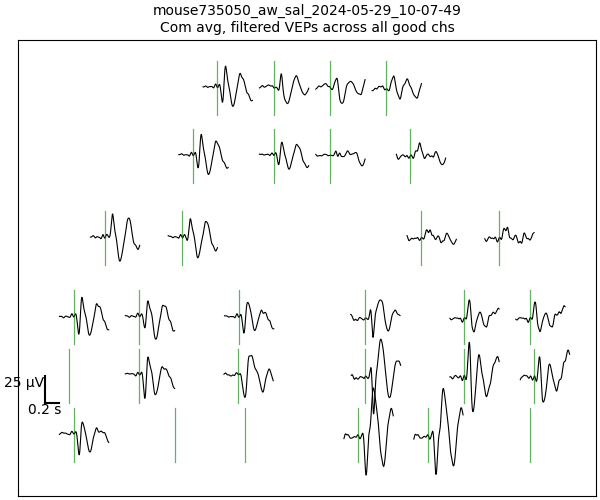

In [25]:
### Make the plot ###
prex = .2 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8 # changes horizontal distance between traces, usually 0.8
ymult = 50 # changes vertical distance between traces, usually 100 for VEPs

timex = event_ts
meantraces = np.mean(pp_event_traces, 2)
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
for chi in range(len(EEG_channel_coordinates)):
    ax.plot(
        timex[pinds] + (EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        meantraces[pinds, chi] + (EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        'k', linewidth=0.8
    )
    # this adds a vertical green line at stim onset time #
    ax.plot([0.+(EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-25+(EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             25+(EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='g', linewidth=0.9, alpha=0.6)
    if chi == 3:
        mx = timex[0] + EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.5
        my = EEG_channel_coordinates['AP'].iloc[chi] * ymult

## This plots a scale bar in the bottom left corner ##
x_len = .2 # x scale bar length in ms
y_len = 25 # y scale bar length in uV, for VEP: 25
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Set title ##
ax.set_title('{}\nCom avg, filtered VEPs across all good chs'.format('mouse' + str(exprow.mouse) + '_' + exprow.exp_folder))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

### Test on one subject

In [13]:
choose_sub = 7
exprow = subselect_df.iloc[choose_sub]
data_path = os.path.join(data_dir, 'mouse'+str(exprow.mouse), exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
print(exprow.mouse)
exp_date = exp.date.strftime("%Y-%m-%d")
print(exp_date)

Experiment type: electrical and sensory stimulation
703064
2023-11-30


In [14]:
## Load stim log ##
stim_log = pd.read_csv(exp.stimulus_log_file)
all_event_times = stim_log['onset'].values

In [15]:
## Get state label for each sweep ##
statelist = []
for char in exprow['sweep_state'].split(','):
    statelist.append(char)
if len(np.unique(stim_log['sweep'].values)) > len(statelist):
    statelist = statelist * len(np.unique(stim_log['sweep'].values))
print(statelist)

['awake', 'psilocybin']


In [16]:
stim_log['state'] = [statelist[x] for x in stim_log['sweep'].values]

In [17]:
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,state
0,biphasic,25,776.05228,776.05268,0.0004,0,awake
1,biphasic,25,782.63824,782.63864,0.0004,0,awake
2,biphasic,35,789.40116,789.40156,0.0004,0,awake
3,biphasic,15,796.70263,796.70303,0.0004,0,awake
4,biphasic,15,803.23229,803.23269,0.0004,0,awake


In [18]:
stim_log.tail()

,stim_type,parameter,onset,offset,duration,sweep,state
715,circle,white,7221.99204,7222.24116,0.24912,1,psilocybin
716,circle,white,7226.44575,7226.69488,0.24913,1,psilocybin
717,circle,white,7230.61592,7230.86507,0.24915,1,psilocybin
718,circle,white,7235.06965,7235.31881,0.24916,1,psilocybin
719,circle,white,7239.80693,7240.05609,0.24916,1,psilocybin


Get the time of visual stimuli relative to the psilocybin injection

In [20]:
exprow.second_inj

4281.370066

In [21]:
psi_stim_log = get_events_wdict(stim_log, {'state': 'psilocybin', 'stim_type': 'circle'}, out='df')
psi_stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,state
600,circle,white,6738.20403,6738.45310,0.24907,1,psilocybin
601,circle,white,6742.49092,6742.74000,0.24908,1,psilocybin
602,circle,white,6746.82788,6747.07696,0.24908,1,psilocybin
603,circle,white,6750.84791,6751.09699,0.24908,1,psilocybin
604,circle,white,6754.78452,6755.03360,0.24908,1,psilocybin


In [22]:
psi_stim_log['time_from_inj'] = psi_stim_log['onset'] - exprow.second_inj

In [23]:
psi_stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,state,time_from_inj
600,circle,white,6738.20403,6738.45310,0.24907,1,psilocybin,2456.833964
601,circle,white,6742.49092,6742.74000,0.24908,1,psilocybin,2461.120854
602,circle,white,6746.82788,6747.07696,0.24908,1,psilocybin,2465.457814
603,circle,white,6750.84791,6751.09699,0.24908,1,psilocybin,2469.477844
604,circle,white,6754.78452,6755.03360,0.24908,1,psilocybin,2473.414454


In [26]:
start_time = psi_stim_log.iloc[0].time_from_inj
stop_time = psi_stim_log.iloc[-1].time_from_inj
print(start_time)
print(stop_time)

2456.8339639999995
2958.4368639999993


Get the ERPs

In [39]:
session_dir = os.path.join(file_save_dir[exprow.drug], 'mouse' + str(exprow.mouse) + '_' + exp_date)
if not os.path.exists(session_dir):
    os.mkdir(session_dir)
else:
    print('Folder already exists: {}!'.format(session_dir))

Folder already exists: C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\Templeton\mouse_EEG_VEPs\white_circles\psilocybin\mouse703064_2023-11-30!


In [40]:
if os.path.exists(os.path.join(session_dir, 'events_preinj.npy')):
    print('Epoched file already exists!')

Epoched file already exists!


In [41]:
## Get EEG bad chs as list ##
EEG_bad_chs = []
if type(exprow.bad_chs) == str:
    for char in exprow.bad_chs.split(','):
        EEG_bad_chs.append(int(char))
print(EEG_bad_chs)

[0, 3]


In [42]:
datai, tsi = exp.load_eegdata() # this loads EEG data in correct mapped order and converted to uV
eeg_chs = np.arange(0, datai.shape[1])

# for bad_chi in EEG_bad_chs:
#     datai[:, bad_chi] = datai[:, bad_chi] * np.nan

## Mask estim artifact ##
if apply_mask:
    print('Applying estim mask')
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(tsi, etime) - 2
        datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]

## Apply high-pass filter ##
if apply_hpass:
    print('Applying high-pass filter')
    hpb, hpa = signal.butter(3, 0.1/(exp.ephys_params['EEG']['sample_rate']/2), btype='highpass')
    datai = signal.filtfilt(hpb, hpa, datai, axis=0)

## Get evoked traces ##
print('Getting EEG event traces')
event_traces, event_ts = get_evoked_traces(
    datai, tsi, all_event_times, -event_window[0], event_window[1], exp.ephys_params['EEG']['sample_rate'])

## Apply lowpass filter ##
if apply_lpass:
    print('Applying low-pass filter')
    lpb, lpa = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
    event_traces = signal.filtfilt(lpb, lpa, event_traces, axis=0)

Getting EEG event traces


In [43]:
print(datai.shape)
print(event_traces.shape)

(19715840, 30)
(10000, 30, 720)


Partition trials to pre/post

In [44]:
processed_data = {}
for ppi, statei in {'pre': 'awake', 'post': exprow.drug}.items():
    event_file = os.path.join(session_dir, 'events_' + ppi + 'inj.npy')
    eventinds = get_events_wdict(stim_log, {'state': statei, 'stim_type': 'circle'}, out='index')
    pp_event_traces = event_traces[:,:,eventinds]

    ## Common average ##
    pp_event_traces = pp_event_traces - np.nanmean(pp_event_traces, axis=1)[:,None,:]

    ## Bandpass filter ##
    bpb, bpa = signal.butter(3, np.array([0.5, 20])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
    pp_event_traces = signal.filtfilt(bpb, bpa, pp_event_traces, axis=0)

    processed_data[ppi] = pp_event_traces

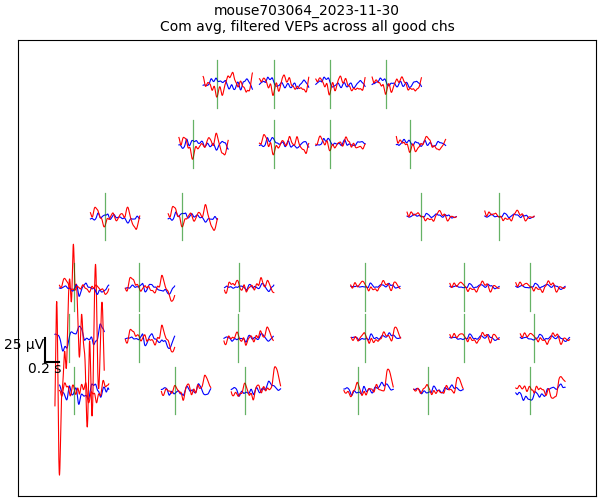

In [45]:
### Make the plot ###
prex = .2 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8 # changes horizontal distance between traces, usually 0.8
ymult = 50 # changes vertical distance between traces, usually 100 for VEPs

timex = event_ts
pretraces = np.mean(processed_data['pre'], 2)
posttraces = np.mean(processed_data['post'], 2)
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
for chi in range(len(EEG_channel_coordinates)):
    ax.plot(
        timex[pinds] + (EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        pretraces[pinds, chi] + (EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        'b', linewidth=0.8
    )
    ax.plot(
        timex[pinds] + (EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        posttraces[pinds, chi] + (EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        'r', linewidth=0.8
    )
    # this adds a vertical green line at stim onset time #
    ax.plot([0.+(EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-25+(EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             25+(EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='g', linewidth=0.9, alpha=0.6)
    if chi == 3:
        mx = timex[0] + EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.5
        my = EEG_channel_coordinates['AP'].iloc[chi] * ymult

## This plots a scale bar in the bottom left corner ##
x_len = .2 # x scale bar length in ms
y_len = 25 # y scale bar length in uV, for VEP: 25
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Set title ##
ax.set_title('{}\nCom avg, filtered VEPs across all good chs'.format('mouse' + str(exprow.mouse) + '_' + exp_date))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

## Save ##
# figname = '{}_prepostVEP.png'.format(subfolder)
# fig.savefig(os.path.join(statefolder, subfolder, figname), transparent=False, dpi=150)

Now partition out trials for white circles in pre/post injection period.